# Kuzushiji-MNIST

https://github.com/rois-codh/kmnist

#### Decompression and File Preparation

Import required modules. Define the FILE_MAP dictionary to associate each compressed .gz file with its uncompressed destination filename. Iterate over the key-value pairs. Check if the uncompressed file already exists and continue to the next file if so. Otherwise, open the compressed .gz file in binary read mode and uncompressed it, writing it out to a file object.

In [1]:
import os, gzip, shutil

FILE_MAP = {
    "train-images-idx3-ubyte.gz": "train-images-idx3-ubyte",
    "train-labels-idx1-ubyte.gz": "train-labels-idx1-ubyte",
    "t10k-images-idx3-ubyte.gz": "t10k-images-idx3-ubyte",
    "t10k-labels-idx1-ubyte.gz": "t10k-labels-idx1-ubyte",
}

for gz_file, file in FILE_MAP.items():
    if os.path.exists(file):
        continue

    with gzip.open(gz_file, "rb") as f_in:
        with open(file, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)


#### Data Loading and Preparation

Import the required libraries and utilities. Define the load_kmnist_images function which opens the specified binary file to read the image pixel data as unsigned 8-bit integers before reshaping the data into 28x28 images, with normalized pixel values. Define the load_kmnist_labels function which opens the label file and reads the label values. Load the uncompressed training images, training labels, test images, and test labels into NumPy arrays. Convert the NumPy arrays into PyTorch tensors and unsqueeze the channel dimension before ensuring the label tensors are of type long. Create the full TensorDataset objects for the training and test data. Calculate the sizes for the training and validation splits using a 10% ratio for validation. Split the full training dataset randomly into the training and validation subsets. Define the batch size as 64. Create the DataLoader objects, shuffling the training data, but not the validation or test data.

In [2]:
import numpy as np
import torch

from torch.utils.data import TensorDataset, DataLoader, random_split

def load_kmnist_images(filename):
    with open(filename, "rb") as f:
        f.seek(16)
        data = np.fromfile(f, dtype=np.uint8)
        return data.reshape(-1, 28, 28).astype(np.float32) / 255.0


def load_kmnist_labels(filename):
    with open(filename, "rb") as f:
        f.seek(8)
        data = np.fromfile(f, dtype=np.uint8)
        return data.reshape(-1)

train_images_np = load_kmnist_images("train-images-idx3-ubyte")
train_labels_np = load_kmnist_labels("train-labels-idx1-ubyte")
test_images_np = load_kmnist_images("t10k-images-idx3-ubyte")
test_labels_np = load_kmnist_labels("t10k-labels-idx1-ubyte")

X_train = torch.from_numpy(train_images_np).unsqueeze(1)
Y_train = torch.from_numpy(train_labels_np).long()
X_test = torch.from_numpy(test_images_np).unsqueeze(1)
Y_test = torch.from_numpy(test_labels_np).long()

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_size = len(train_dataset)
split_ratio = 0.1
val_size = int(split_ratio * train_size)
new_train_size = train_size - val_size

train_data, val_data = random_split(train_dataset, [new_train_size, val_size])

batch_size = 64

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### Data Verification and Metrics

Print the shape of the full training image tensor (X_train) and the training label tensor (Y_train). Print the shape of the test image tensor (X_test) and the test label tensor (Y_test). Display the data type of the X_train tensor and the Y_train tensor. Output the normalized pixel value of a single example image at a specific coordinate from X_train. Output the integer label value of the first example from Y_train. Print the total number of examples in the final training data subset, the validation data subset, and the test dataset.

In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

print(f"\nX_train data type: {X_train.dtype}")
print(f"Y_train data type: {Y_train.dtype}")

print(f"\nExample pixel value: {X_train[0, 0, 14, 14].item()}")
print(f"Example label value: {Y_train[0].item()}")

print(f"\nTotal training examples: {len(train_data)}")
print(f"Total validation examples: {len(val_data)}")
print(f"Total test examples: {len(test_dataset)}")

X_train shape: torch.Size([60000, 1, 28, 28])
Y_train shape: torch.Size([60000])
X_test shape: torch.Size([10000, 1, 28, 28])
Y_test shape: torch.Size([10000])

X_train data type: torch.float32
Y_train data type: torch.int64

Example pixel value: 0.0
Example label value: 8

Total training examples: 54000
Total validation examples: 6000
Total test examples: 10000


#### Sample Data Visualization

Import matplotlib. Initialize an iterator for the training data loader. Retrieve the next batch of images and labels from the training data. Create a new figure for plotting. Iterate ten times to display ten sample images from the training data, the validation data, and the test data.

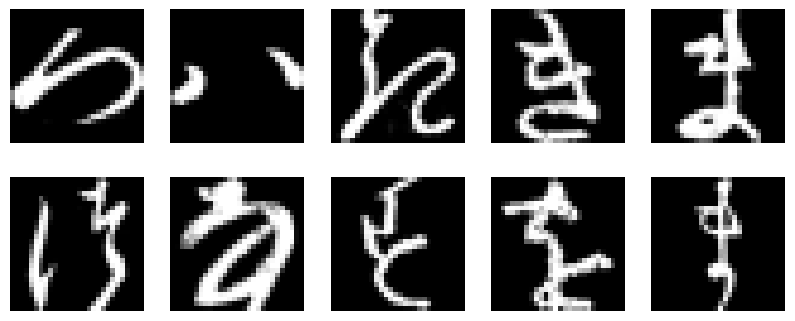

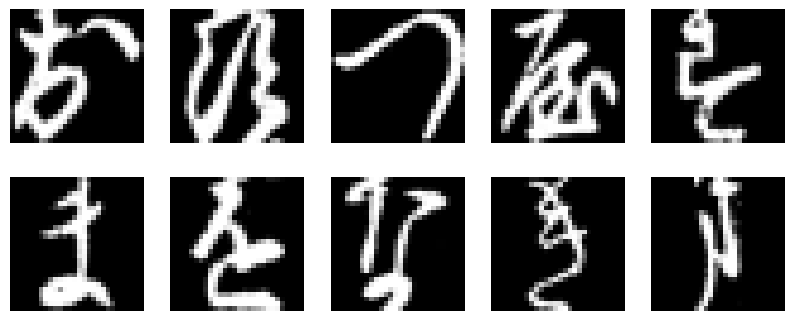

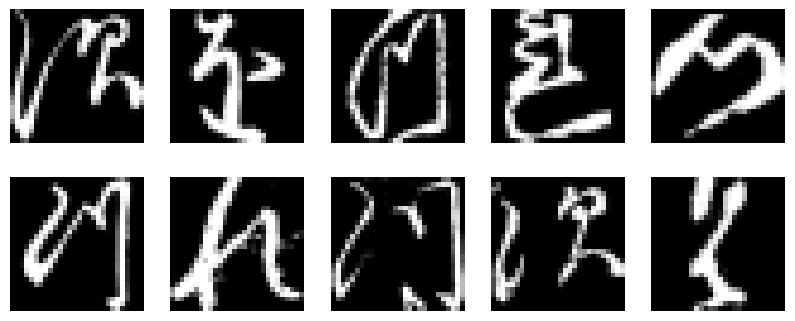

In [4]:
import matplotlib.pyplot as plt

# training samples
data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 4))

for i in range(10):
    img = images[i].squeeze().numpy()
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.show()

# validation samples
data_iter = iter(val_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 4))

for i in range(10):
    img = images[i].squeeze().numpy()
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.show()

# test samples
data_iter = iter(test_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 4))

for i in range(10):
    img = images[i].squeeze().numpy()
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

plt.show()

#### CNN Model 1 Initialization

Import PyTorch libraries. Define the SimpleCNN1 class. Initialize the layers of the model: a 2D convolutional layer with 32 output channels, a max pooling layer that uses a 2x2 window, a second 2D convolutional layer with 64 output channels, and two fully connected linear layers that eventually reduces down to 10 outputs. Define the forward pass: apply the first convolution, then the ReLU activation and max pooling. Apply the second convolution, then the ReLU activation and max pooling. Flatten the resulting tensor into a single vector. Pass the vector through the first linear layer with ReLU activation. Pass the result through the final linear layer to produce the 10 class scores.

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SimpleCNN1(nn.Module):
    def __init__(self):
        super(SimpleCNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print(SimpleCNN1())

SimpleCNN1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


#### Model Evaluation Function

Factor out an evaluate_model function that accepts a model and data loader. Switch the model to evaluation mode. Initialize the prediction count and total sample count to zero. Enter a context where gradient tracking is disabled. Iterate through the images and labels in the data loader. Pass the images through the model to obtain outputs. Determine the predicted class index by finding the maximum output value. Accumulate the batch size to the total count. Accumulate the number of accurate predictions to the correct count. Calculate and return the final accuracy.

In [6]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

#### CNN Model 1 Training and Evaluation

Define an evaluate_model function that finds the predicted class with the highest score, and accumulates the total and correct counts before calculating and returning the accuracy as a percentage. Initialize the training hyperparameter variables. Begin the training loop. Set model_1 to training mode and initialize the running_loss. Execute the inner loop over the training data batches: zero the optimizer gradients, calculate the model output, compute the loss, perform backpropagation, update the weights using the optimizer, and accumulate the loss. Switch model_1 to evaluation mode and initialize val_loss. Execute the validation loop over the validation data batches, accumulating the validation loss without tracking gradients. Calculate the average validation loss for the epoch. Implement the early stopping logic: check if the average validation loss is less than the current best_val_loss. If it is, update best_val_loss and reset the no_improvement_count. Otherwise, increment the no_improvement_count, and if the count equals the patience limit, break the loop. Print the epoch's training and validation loss results. Calculate the final accuracy and print the result. Save the parameters to the kmnist_model_1_weights.pth file.

In [7]:
model_1 = SimpleCNN1()
criterion = nn.CrossEntropyLoss()

learning_rate_1 = 0.001
optimizer_1 = optim.Adam(model_1.parameters(), lr=learning_rate_1)


max_epochs = 30
patience = 3
best_val_loss = float("inf")
no_improvement_count = 0


for epoch in range(max_epochs):

    # train
    model_1.train()
    running_loss = 0.0
    for images, labels in train_loader:

        optimizer_1.zero_grad()

        outputs = model_1(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_1.step()

        running_loss += loss.item()

    # validate
    model_1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_1(images)
            val_loss += criterion(outputs, labels).item()

    avg_val_loss = val_loss / len(val_loader)

    # early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

        if no_improvement_count == patience:
            print(
                f"\nEarly stopping at epoch {epoch+1}.  Validation loss did not improve for {patience} epochs."
            )
            break

    print(
        f"Epoch {epoch + 1:02d}/{max_epochs}:  Training loss: {running_loss/len(train_loader):.4f}  Validation loss: {avg_val_loss:.4f}"
    )


accuracy = evaluate_model(model_1, test_loader)
print(f"\nTest set accuracy: {accuracy:.2f}%")

torch.save(model_1.state_dict(), "kmnist_model_1_weights.pth")

Epoch 01/30:  Training loss: 0.5182  Validation loss: 0.2520
Epoch 02/30:  Training loss: 0.1950  Validation loss: 0.1757
Epoch 03/30:  Training loss: 0.1392  Validation loss: 0.1489
Epoch 04/30:  Training loss: 0.1073  Validation loss: 0.1439
Epoch 05/30:  Training loss: 0.0859  Validation loss: 0.1125
Epoch 06/30:  Training loss: 0.0700  Validation loss: 0.1087
Epoch 07/30:  Training loss: 0.0562  Validation loss: 0.1035
Epoch 08/30:  Training loss: 0.0479  Validation loss: 0.1012
Epoch 09/30:  Training loss: 0.0390  Validation loss: 0.1031
Epoch 10/30:  Training loss: 0.0304  Validation loss: 0.1149

Early stopping at epoch 11.  Validation loss did not improve for 3 epochs.

Test set accuracy: 92.83%


#### CNN Model 2 Architecture Definition

Define the SimpleCNN2 model. Initialize the layers: the first 2D convolutional layer (1 input channel, 16 output channels) uses a larger 5x5 kernel than model 1 for broader initial feature extraction. A max pooling layer is defined next. Then two fully connected linear layers (fc1 and fc2) are added to perform the final classification. Define the forward method, which specifies the sequential data flow: apply ReLU activation and max pooling after the convolution. Flatten the output of the convolutional layers into a vector. Pass the vector through the two fully connected layers to produce the 10 class scores.

In [8]:
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 12 * 12, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print(SimpleCNN2())

SimpleCNN2(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


#### CNN Model 2 Training and Evaluation

Instantiate the SimpleCNN2 class as model_2. Set a different learning rate than model_1, to 0.01. Instantiate the Adam optimizer and initialize the early stopping variables. Begin the main training loop, iterating up to max_epochs. Set model_2 to training mode and initialize running_loss. Execute the inner loop over training data batches. Switch model_2 to evaluation mode and initialize val_loss. Execute the validation loop over validation data batches, accumulating the validation loss without gradient tracking. Calculate the average validation loss for the epoch. Execute the early stopping conditional check. Print the epoch's training and validation loss results using two-digit epoch formatting. Calculate and print the final accuracy. Save the optimized parameters of model_2 in the kmnist_model_2_weights.pth file.

In [9]:
model_2 = SimpleCNN2()

learning_rate_2 = 0.01
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate_2)

best_val_loss = float("inf")
no_improvement_count = 0


for epoch in range(max_epochs):

    # train
    model_2.train()
    running_loss = 0.0
    for images, labels in train_loader:

        optimizer_2.zero_grad()

        outputs = model_2(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_2.step()

        running_loss += loss.item()

    # validate
    model_2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_2(images)
            val_loss += criterion(outputs, labels).item()

    avg_val_loss = val_loss / len(val_loader)

    # early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        
        if no_improvement_count == patience:
            print(
                f"\nEarly stopping at Epoch {epoch + 1:02d}. Validation loss did not improve for {patience} epochs."
            )
            break

    print(
        f"Epoch {epoch + 1:02d}/{max_epochs}:  Training loss: {running_loss/len(train_loader):.4f}  Validation loss: {avg_val_loss:.4f}"
    )

accuracy = evaluate_model(model_2, test_loader)
print(f"\nTest set accuracy for CNN 2: {accuracy:.2f}%")

torch.save(model_2.state_dict(), "kmnist_model_2_weights.pth")

Epoch 01/30:  Training loss: 0.4344  Validation loss: 0.2221
Epoch 02/30:  Training loss: 0.2054  Validation loss: 0.1942
Epoch 03/30:  Training loss: 0.1578  Validation loss: 0.1793
Epoch 04/30:  Training loss: 0.1353  Validation loss: 0.1841
Epoch 05/30:  Training loss: 0.1193  Validation loss: 0.2229

Early stopping at Epoch 06. Validation loss did not improve for 3 epochs.

Test set accuracy for CNN 2: 87.29%


#### CNN Model 3 Architecture Definition

Define the SimpleCNN3 model. Initialize the layers of the model: create the first 2D convolutional layer using 48 output channels and a minimal 1x1 kernel size. Define a max pooling layer. Create the second 2D convolutional layer using 96 output channels and a minimal 1x1 kernel size. Define two fully connected linear layers, reducing the feature count down to 10 classes. Define the forward pass: apply the first convolution, ReLU activation, and max pooling. Apply the second convolution, ReLU, and max pooling. Flatten the resulting tensor into a single vector. Pass the vector through the two fully connected layers to produce the final 10 class scores.

In [10]:
class SimpleCNN3(nn.Module):
    def __init__(self):
        super(SimpleCNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(48, 96, 1)
        self.fc1 = nn.Linear(96 * 7 * 7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 96 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print(SimpleCNN3())

SimpleCNN3(
  (conv1): Conv2d(1, 48, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=4704, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


### CNN Model 3 Training and Evaluation

Instantiate the model and Adam optimizer using a learning rate of 0.001. Initialize the early stopping parameters. Execute the main training loop: set the model to training mode, iterate over the train_loader, zero gradients, calculate output and loss, backpropagate, and update the weights. Switch the model to evaluation mode and calculate the average validation loss. Apply the early stopping logic. Print the epoch's loss metrics. Calculate and print the final accuracy. Save the model.

In [11]:
model_3 = SimpleCNN3()

learning_rate_3 = 0.001
optimizer_3 = optim.Adam(model_3.parameters(), lr=learning_rate_3)

best_val_loss = float("inf")
no_improvement_count = 0

for epoch in range(max_epochs):

    # training
    model_3.train()
    running_loss = 0.0

    for images, labels in train_loader:

        optimizer_3.zero_grad()

        outputs = model_3(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_3.step()

        running_loss += loss.item()

    # validation
    model_3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_3(images)
            val_loss += criterion(outputs, labels).item()

    avg_val_loss = val_loss / len(val_loader)

    # early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        
        if no_improvement_count == patience:
            print(
                f"\nEarly stopping at Epoch {epoch + 1:02d}.  Validation loss did not improve for {patience} epochs."
            )
            break

    print(
        f"Epoch {epoch + 1:02d}/{max_epochs}:  Training loss: {running_loss/len(train_loader):.4f}  Validation loss: {avg_val_loss:.4f}"
    )

accuracy = evaluate_model(model_3, test_loader)
print(f"\nTest set accuracy for CNN 3: {accuracy:.2f}%")

torch.save(model_3.state_dict(), "kmnist_model_3_weights.pth")

Epoch 01/30:  Training loss: 0.9011  Validation loss: 0.7123
Epoch 02/30:  Training loss: 0.6746  Validation loss: 0.6407
Epoch 03/30:  Training loss: 0.6155  Validation loss: 0.6105
Epoch 04/30:  Training loss: 0.5838  Validation loss: 0.6007
Epoch 05/30:  Training loss: 0.5639  Validation loss: 0.5943
Epoch 06/30:  Training loss: 0.5513  Validation loss: 0.5774
Epoch 07/30:  Training loss: 0.5400  Validation loss: 0.5589
Epoch 08/30:  Training loss: 0.5289  Validation loss: 0.5576
Epoch 09/30:  Training loss: 0.5227  Validation loss: 0.5679
Epoch 10/30:  Training loss: 0.5173  Validation loss: 0.5533
Epoch 11/30:  Training loss: 0.5137  Validation loss: 0.5550
Epoch 12/30:  Training loss: 0.5072  Validation loss: 0.5470
Epoch 13/30:  Training loss: 0.5034  Validation loss: 0.5329
Epoch 14/30:  Training loss: 0.4979  Validation loss: 0.5617
Epoch 15/30:  Training loss: 0.4940  Validation loss: 0.5484

Early stopping at Epoch 16.  Validation loss did not improve for 3 epochs.

Test set

#### Reload base models

Instantiate the SimpleCNN1 class as model_1 amd load its saved parameters. Do the same for model_2 and model_3. Print the evaluated models.

In [12]:
model_1 = SimpleCNN1()
model_1.load_state_dict(torch.load("kmnist_model_1_weights.pth"))
print('model_1:', model_1.eval())

model_2 = SimpleCNN2()
model_2.load_state_dict(torch.load("kmnist_model_2_weights.pth"))
print('model_2:', model_2.eval())

model_3 = SimpleCNN3()
model_3.load_state_dict(torch.load("kmnist_model_3_weights.pth"))
print('model_3:', model_3.eval())

model_1: SimpleCNN1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
model_2: SimpleCNN2(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
model_3: SimpleCNN3(
  (conv1): Conv2d(1, 48, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=4704, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


#### Stacking Data Generation

Import the required liraries, KFold and Subset. Define an instance of TensorDataset. Set the number of folds and instantiate the KFold object. Initialize the S_train NumPy array. Convert the true training labels (Y_train) to a NumPy array for the meta-learner (Y_train_meta). Group the three CNN base models (model_1, model_2, model_3) into the models list. Begin the cross-validation loop over the folds. Create a validation subset of the data for the current fold and instantiate a DataLoader for it. Disable gradient tracking and iterate over the three base models. Generate prediction probabilities for all images in the current validation subset. Concatenate the batch predictions. Place the 10 probabilities into the correct 10 columns of the S_train matrix for the current fold's indices.

In [13]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

full_train_dataset = TensorDataset(X_train, Y_train)

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=17)

S_train = np.zeros((len(full_train_dataset), 3 * 10))
Y_train_meta = Y_train.numpy()

models = [model_1, model_2, model_3]
start_idx = 0


for fold, (train_index, val_index) in enumerate(kf.split(full_train_dataset)):
    print(f"Processing Fold {fold + 1}/{num_folds}...")

    val_subset = Subset(full_train_dataset, val_index)
    val_loader_fold = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    fold_predictions = []

    with torch.no_grad():
        for model_idx, model in enumerate(models):
            model_preds = []

            for images, _ in val_loader_fold:
                outputs = model(images)
                probs = F.softmax(outputs, dim=1).cpu().numpy()
                model_preds.append(probs)

            model_preds = np.concatenate(model_preds, axis=0)

            S_train[val_index, model_idx * 10 : (model_idx + 1) * 10] = model_preds

Processing Fold 1/5...
Processing Fold 2/5...
Processing Fold 3/5...
Processing Fold 4/5...
Processing Fold 5/5...


#### Ensemble Training

Import LogisticRegression and instantiate a new model. Set the solver to lbfgs and the maximum number of iterations to 1000. Train the meta_model by fitting it to the training features (S_train) and the training labels (Y_train_meta). Initialize the S_test NumPy array, which will store the test features for the final predictions. Disable gradient tracking and iterate over the three trained base models. Inside the loop, iterate over the test_loader batches, calculate model outputs, convert them to softmax probabilities, and store the predictions. Concatenate the predictions into batches. Place the 30 prediction probabilities into S_test matrix by column.

In [14]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(solver="lbfgs", max_iter=1000)
meta_model.fit(S_train, Y_train_meta)

S_test = np.zeros((len(test_dataset), 3 * 10))

with torch.no_grad():
    for model_idx, model in enumerate(models):

        test_preds = []
        for images, _ in test_loader:
            outputs = model(images)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            test_preds.append(probs)

        model_preds_test = np.concatenate(test_preds, axis=0)
        S_test[:, model_idx * 10 : (model_idx + 1) * 10] = model_preds_test

print(f"Coefficients shape: {meta_model.coef_.shape}")
print(meta_model.coef_[0, :10])

Coefficients shape: (10, 30)
[ 5.21781403 -0.27531379 -0.36587449 -0.2333684  -0.94998567 -0.65438392
 -0.71420089 -0.61358854 -0.9604001  -0.49530742]


#### Ensemble Evaluation and Visualization

Import the required libraries. Set the Matplotlib default font to a Unicode-compatible family to ensure the all characters display correctly. Convert the PyTorch test labels to a NumPy array. Generate the final predictions by applying the trained meta_model to the S_test features. Calculate the confusion matrix using the true and predicted labels. Define the 10 Hiragana characters for display labels. Instantiate the ConfusionMatrixDisplay object using the calculated matrix and the defined labels. Create the figure and axes for the plot. Plot the confusion matrix and set the plot title. Display the confusion matrix.


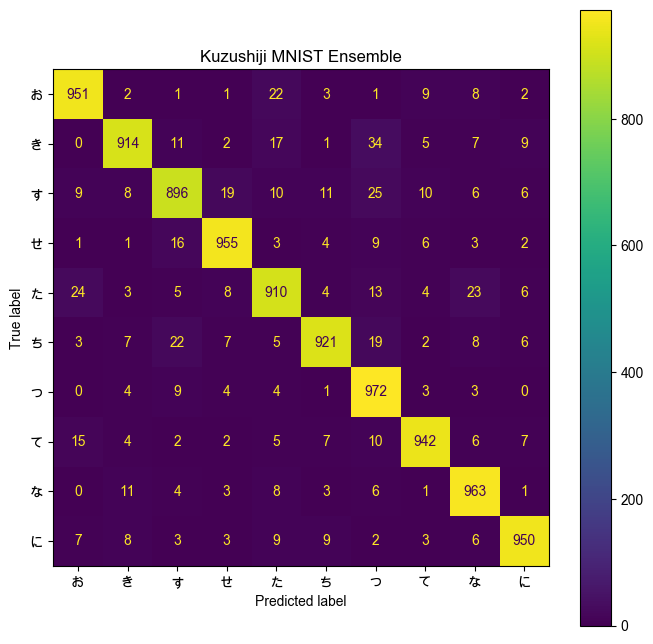

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams["font.family"] = ["Arial Unicode MS", "sans-serif"]

Y_test_np = Y_test.numpy()
final_ensemble_predictions = meta_model.predict(S_test)
cm = confusion_matrix(Y_test_np, final_ensemble_predictions)

display_labels = ["お", "き", "す", "せ", "た", "ち", "つ", "て", "な", "に"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title("Kuzushiji MNIST Ensemble")
plt.show()

#### Performance Metrics

Import the performance metrics helper functions. Generate the final predictions by applying the trained meta_model to the S_test features. Convert the PyTorch test labels to a NumPy array. Calculate the ensemble_accuracy by comparing predictions to true labels. Calculate the ensemble_f1_score using the macro average to equally weight performance across all 10 classes. Generate the final ensemble probability scores from the meta_model. Calculate the ensemble_log_loss using the probability scores. Print the calculated values.

In [16]:
from sklearn.metrics import accuracy_score, f1_score, log_loss

final_ensemble_predictions = meta_model.predict(S_test)
Y_test_np = Y_test.numpy()

ensemble_accuracy = accuracy_score(Y_test_np, final_ensemble_predictions)
ensemble_f1_score = f1_score(Y_test_np, final_ensemble_predictions, average="macro")
ensemble_probs = meta_model.predict_proba(S_test)
ensemble_log_loss = log_loss(Y_test_np, ensemble_probs)

print(f"Ensemble Accuracy: {ensemble_accuracy * 100:.2f}%")
print(f"Ensemble F1 Score (Macro): {ensemble_f1_score:.4f}")
print(f"Ensemble Log Loss: {ensemble_log_loss:.4f}")

Ensemble Accuracy: 93.74%
Ensemble F1 Score (Macro): 0.9374
Ensemble Log Loss: 0.2888


#### Rearchitect Model 2

Model 2 is the worst performing model.  Rework the architecture.

Redefine the SimpleCNN2 class. Initialize the layers of the model. Create the first 2D convolutional layer using 32 output channels and a 5x5 kernel. Define a 2x2 max pooling layer. Create the second 2D convolutional layer using 64 output channels and a 3x3 kernel. Define two fully connected linear layers, projecting the features down to 10 final outputs. Define the forward pass: apply the first convolution, ReLU activation, and max pooling. Apply the second convolution, ReLU activation, and max pooling. Flatten the resulting tensor into a vector. Pass the vector through the two fully connected layers, using ReLU activation after the first. Return the final 10 class scores.

In [17]:
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

print(SimpleCNN2())

SimpleCNN2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


#### Retrain Model 2

Instantiate the new SimpleCNN2 class. Set the learning rate. Instantiate a new Adam optimizer. Initialize the early stopping variables. Begin the main training loop, iterating up to max_epochs. Execute the inner training loop. Set the model to training mode. Zero the gradients and calculate output and loss. Perform backpropagation, update the weights, and accumulate the loss. Switch the model to evaluation mode. Execute the validation loop accumulating the validation loss without gradient tracking. Calculate the average validation loss. Apply the early stopping check. Calculate the final accuracy. Save the new model to disk.

In [18]:
model_2 = SimpleCNN2()

learning_rate_2 = 0.0005
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate_2)

best_val_loss = float("inf")
no_improvement_count = 0


for epoch in range(max_epochs):

    # train
    model_2.train()
    running_loss = 0.0
    for images, labels in train_loader:

        optimizer_2.zero_grad()

        outputs = model_2(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_2.step()

        running_loss += loss.item()

    # validate
    model_2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_2(images)
            val_loss += criterion(outputs, labels).item()

    avg_val_loss = val_loss / len(val_loader)

    # early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

        if no_improvement_count == patience:
            print(
                f"\nEarly stopping at Epoch {epoch + 1:02d}. Validation loss did not improve for {patience} epochs."
            )
            break

    print(
        f"Epoch {epoch + 1:02d}/{max_epochs}:  Training loss: {running_loss/len(train_loader):.4f}  Validation loss: {avg_val_loss:.4f}"
    )

accuracy = evaluate_model(model_2, test_loader)
print(f"\nTest set accuracy for CNN 2: {accuracy:.2f}%")

torch.save(model_2.state_dict(), "kmnist_model_2_weights.pth")

Epoch 01/30:  Training loss: 0.4502  Validation loss: 0.1753
Epoch 02/30:  Training loss: 0.1413  Validation loss: 0.1158
Epoch 03/30:  Training loss: 0.0885  Validation loss: 0.0927
Epoch 04/30:  Training loss: 0.0614  Validation loss: 0.0809
Epoch 05/30:  Training loss: 0.0446  Validation loss: 0.0801
Epoch 06/30:  Training loss: 0.0343  Validation loss: 0.0811
Epoch 07/30:  Training loss: 0.0254  Validation loss: 0.0818
Epoch 08/30:  Training loss: 0.0176  Validation loss: 0.0771
Epoch 09/30:  Training loss: 0.0141  Validation loss: 0.0770
Epoch 10/30:  Training loss: 0.0106  Validation loss: 0.0868
Epoch 11/30:  Training loss: 0.0107  Validation loss: 0.0740
Epoch 12/30:  Training loss: 0.0076  Validation loss: 0.0880
Epoch 13/30:  Training loss: 0.0066  Validation loss: 0.0883

Early stopping at Epoch 14. Validation loss did not improve for 3 epochs.

Test set accuracy for CNN 2: 95.30%


#### Rearchitect model 3

Model 3 is the second worst performer. Rearchitect it.

Redefine the SimpleCNN3 class. Initialize the layers of the model. Define a 2x2 average pooling layer. Create the first 2D convolutional layer using 48 output channels and a 3x3 kernel. Create the second 2D convolutional layer using 96 output channels. Define two fully connected linear layers to reduce features to 10 output scores. Define the forward pass: apply the first convolution, then the LeakyReLU activation and average pooling. Apply the second convolution, then the LeakyReLU activation and average pooling. Flatten the resulting tensor into a vector. Pass the vector through the two linear layers, using LeakyReLU activation after the first.

In [19]:
class SimpleCNN3(nn.Module):
    def __init__(self):
        super(SimpleCNN3, self).__init__()
        self.pool = nn.AvgPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 48, 3)
        self.conv2 = nn.Conv2d(48, 96, 3)
        self.fc1 = nn.Linear(96 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = x.view(-1, 96 * 5 * 5)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
print(SimpleCNN3())

SimpleCNN3(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


#### Retrain Model 3

Instantiate the new SimpleCNN3. Instantiate the Adam optimizer, using the same learning rate as with the previous version model 3. Initialize the early stopping variables. Begin the main training loop. Set the model to training mode. Execute the inner loop. Zero the gradients and calculate output and loss. Perform backpropagation, update the weights, and accumulate the loss. Switch the model to evaluation mode. Execute the validation loop accumulating the validation loss without gradient tracking. Calculate the average validation loss. Check the early stopping condition. Print training and validation loss results. Calculate the final accuracy of the model. Print the accuracy for the reworked CNN model 3. Save the model to disk.

In [20]:
model_3 = SimpleCNN3()

optimizer_3 = optim.Adam(model_3.parameters(), lr=learning_rate_3)

best_val_loss = float("inf")
epochs_no_improve = 0


for epoch in range(max_epochs):

    # training
    model_3.train()
    running_loss = 0.0
    for images, labels in train_loader:

        optimizer_3.zero_grad()
        outputs = model_3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_3.step()

        running_loss += loss.item()

    # validation
    model_3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_3(images)
            val_loss += criterion(outputs, labels).item()

    avg_val_loss = val_loss / len(val_loader)

    # early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        
        if no_improvement_count == patience:
            print(
                f"Early stopping at Epoch {epoch + 1:02d}. Validation loss did not improve for {patience} epochs."
            )
            break

    print(
        f"Epoch {epoch + 1:02d}/{max_epochs}:  Training Loss: {running_loss/len(train_loader):.4f}  Validation Loss: {avg_val_loss:.4f}"
    )


accuracy = evaluate_model(model_3, test_loader)
print(f"\nTest set accuracy for Reworked CNN 3: {accuracy:.2f}%")

torch.save(model_3.state_dict(), "kmnist_model_3_weights.pth")

Epoch 01/30:  Training Loss: 0.3694  Validation Loss: 0.1499
Epoch 02/30:  Training Loss: 0.1149  Validation Loss: 0.0928
Epoch 03/30:  Training Loss: 0.0697  Validation Loss: 0.0892
Epoch 04/30:  Training Loss: 0.0493  Validation Loss: 0.0722
Epoch 05/30:  Training Loss: 0.0339  Validation Loss: 0.0745
Epoch 06/30:  Training Loss: 0.0234  Validation Loss: 0.0747
Early stopping at Epoch 07. Validation loss did not improve for 3 epochs.

Test set accuracy for Reworked CNN 3: 93.80%


#### Reload the models including the updated model 2 and model 3

Instantiate the SimpleCNN1 class as model_1 amd load its saved parameters. Do the same for the new model_2 and new model_3. Print the evaluated models.

In [21]:
model_1 = SimpleCNN1()
model_1.load_state_dict(torch.load("kmnist_model_1_weights.pth"))
print("model_1:", model_1.eval())

model_2 = SimpleCNN2()
model_2.load_state_dict(torch.load("kmnist_model_2_weights.pth"))
print("model_2:", model_2.eval())

model_3 = SimpleCNN3()
model_3.load_state_dict(torch.load("kmnist_model_3_weights.pth"))
print("model_3:", model_3.eval())

model_1: SimpleCNN1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
model_2: SimpleCNN2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
model_3: SimpleCNN3(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, ou

#### Re-stacking Data Generation

Define an instance of TensorDataset. Set the number of folds and instantiate the KFold object. Initialize the S_train NumPy array. Convert the training labels to a NumPy array. Group the three CNN base models into the models list. Begin the cross-validation loop over the folds. Create a validation subset of the data for the current fold and instantiate a DataLoader for it. Disable gradient tracking and iterate over the three base models. Generate prediction probabilities for all images in the current validation subset. Concatenate the batch predictions. Place the 10 probabilities into the correct 10 columns of the S_train matrix for the current fold's indices.

In [22]:
full_train_dataset = TensorDataset(X_train, Y_train)

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=17)

S_train = np.zeros((len(full_train_dataset), 3 * 10))
Y_train_meta = Y_train.numpy()

models = [model_1, model_2, model_3]
start_idx = 0


for fold, (train_index, val_index) in enumerate(kf.split(full_train_dataset)):
    print(f"Processing Fold {fold + 1}/{num_folds}...")

    val_subset = Subset(full_train_dataset, val_index)
    val_loader_fold = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    fold_predictions = []

    with torch.no_grad():
        for model_idx, model in enumerate(models):
            model_preds = []

            for images, _ in val_loader_fold:
                outputs = model(images)
                probs = F.softmax(outputs, dim=1).cpu().numpy()
                model_preds.append(probs)

            model_preds = np.concatenate(model_preds, axis=0)

            S_train[val_index, model_idx * 10 : (model_idx + 1) * 10] = model_preds

Processing Fold 1/5...
Processing Fold 2/5...
Processing Fold 3/5...
Processing Fold 4/5...
Processing Fold 5/5...


#### Ensemble Re-training

Instantiate a new LogisticRegression instance. Set the solver to lbfgs and the maximum number of iterations to 1000. Train the meta_model by fitting it to the training features and the training labels. Initialize the NumPy array, which will store the test features for the final predictions. Disable gradient tracking and iterate over the three trained base models. Inside the loop, iterate over the test_loader batches and calculate model outputs. Convert the outputs to softmax probabilities and store the predictions. Concatenate the predictions into batches. Place the 30 prediction probabilities into the matrix by column.

In [23]:
meta_model = LogisticRegression(solver="lbfgs", max_iter=1000)
meta_model.fit(S_train, Y_train_meta)

S_test = np.zeros((len(test_dataset), 3 * 10))

with torch.no_grad():
    for model_idx, model in enumerate(models):

        test_preds = []
        for images, _ in test_loader:
            outputs = model(images)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            test_preds.append(probs)

        model_preds_test = np.concatenate(test_preds, axis=0)
        S_test[:, model_idx * 10 : (model_idx + 1) * 10] = model_preds_test

print(f"Coefficients shape: {meta_model.coef_.shape}")
print(meta_model.coef_[0, :10])

Coefficients shape: (10, 30)
[ 2.61647046 -0.19811334 -0.26071026 -0.24875666 -0.22421122 -0.32453966
 -0.37549658 -0.28490725 -0.35796009 -0.30892527]


#### Ensemble Evaluation and Visualization After model 2 and model 3 Updates

Calculate the confusion matrix using the true and predicted labels. Instantiate the ConfusionMatrixDisplay object using the calculated matrix and the defined labels. Create the figure and axes for the plot. Plot the confusion matrix and set the plot title. Display the confusion matrix.

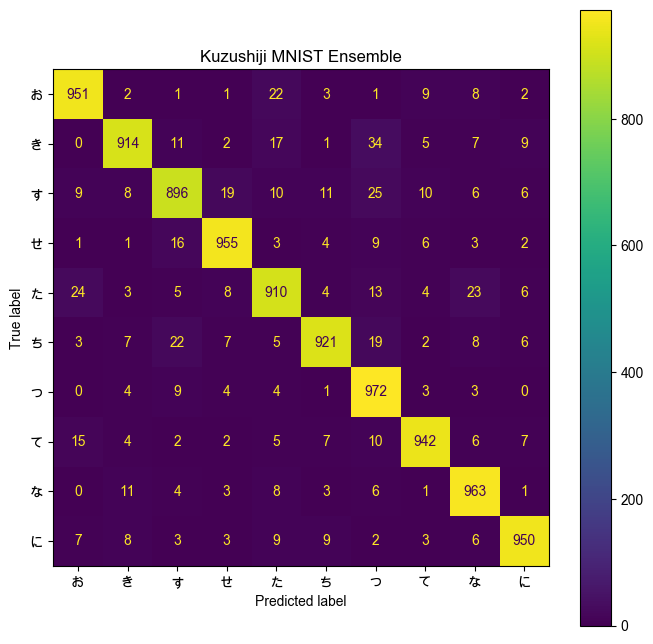

In [24]:
cm = confusion_matrix(Y_test_np, final_ensemble_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title("Kuzushiji MNIST Ensemble")
plt.show()

#### Improved Performance Metrics

Generate the final predictions. Convert the PyTorch test labels to a NumPy array. Calculate the ensemble_accuracy by comparing predictions to true labels. Calculate the ensemble_f1_score using the macro average to equally weight performance across all 10 classes. Generate the final ensemble probability scores from the meta_model. Calculate the ensemble_log_loss using the probability scores. Print the calculated values.

In [25]:
final_ensemble_predictions = meta_model.predict(S_test)
Y_test_np = Y_test.numpy()

ensemble_accuracy = accuracy_score(Y_test_np, final_ensemble_predictions)
ensemble_f1_score = f1_score(Y_test_np, final_ensemble_predictions, average="macro")
ensemble_probs = meta_model.predict_proba(S_test)
ensemble_log_loss = log_loss(Y_test_np, ensemble_probs)

print(f"Ensemble Accuracy: {ensemble_accuracy * 100:.2f}%")
print(f"Ensemble F1 Score (Macro): {ensemble_f1_score:.4f}")
print(f"Ensemble Log Loss: {ensemble_log_loss:.4f}")

Ensemble Accuracy: 96.05%
Ensemble F1 Score (Macro): 0.9605
Ensemble Log Loss: 0.1942
